In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
import torchvision 
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from  torch.autograd import Variable
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
from sklearn.metrics import accuracy_score
import random

### Plot Confusion Matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Cifar10 Dataset loader

In [25]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

print('Number of training images',len(trainset))
print('Number of testing images' , len(testset))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Number of training images 50000
Number of testing images 10000


### Create Confusion Matrix

In [26]:
def create_confusion_matrix(y_valid , y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_valid, y_pred)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes)

    plt.show()

### Extract a batch of images and display them 

In [27]:
def show_batch():
        
    len_dataset = len(trainset)
    
    #sample some images 
    rlst = random.sample(range(len_dataset), 9)
                         
    #loop over the indices and plot the images as sub-figures 
    j = 0 
    for i in rlst:
        img , lbl = trainset[i]
        img =  img.resize((300, 300), Image.ANTIALIAS)
        plt.subplot(3, 3, j + 1)
        plt.title(classes[lbl])
        plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
        plt.imshow(img)
        
        j+=1
    plt.show()

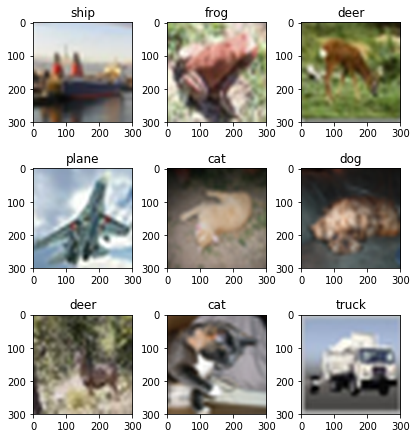

In [28]:
show_batch()

### Preprocessing of images 

Here we use different processing approaches for testing and training 

In [75]:
trainset_transform = transforms.Compose([
                                      transforms.RandomSizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                                                

validset_transform = transforms.Compose([
                                        transforms.Scale(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Encapsulate a a dataloader class 

The Dataloader class is responsible for taking batches at each traing/validation step

In [66]:
BATCH_SIZE = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True , transform = trainset_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True , transform =validset_transform )

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


### Use GPU

In [67]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


### ResNet Pretrained Model 

In [68]:
model = models.resnet18(pretrained=True)

### Model finetuning 

Simply replace the last layer which contains 1000 neurons of ImageNet to 10 of cifar10 

In [69]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
if use_gpu:
    model = model.cuda()

### Optimizer 

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

### Training 

In [73]:
def train_model(model, criterion, optimizer,show_confusion_matrix = True,  num_epochs=3):
    since = time.time()

    best_acc = 0.0
    best_lbl_prd = []
    best_lbl_tru = []
        
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

         # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            i = 0 
                
            loader = trainloader
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                loader = testloader 
            
            #calculate epoch loss
            running_loss = 0.0
            running_corrects = 0
            
            #save predictted and tru labeling 
            lbl_prd_val = [] 
            lbl_tru_val = []
            
            # Iterate over data.
            cnt = 0 
            for i_batch, batch in enumerate(loader):
                
                # get the inputs ,lbls of the batch 
                inputs , labels = batch 
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.float().cuda())
                    labels = Variable(labels.long().cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                #evaluate the loss
                loss = criterion(outputs, labels)
                
                #backprop in training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    lbl_tru_val = np.concatenate((lbl_tru_val , labels.data.cpu().numpy()),0)
                    lbl_prd_val = np.concatenate((lbl_prd_val , preds.cpu().numpy()),0)
                    
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                i+=1
            #evaluate the model according to type
            if phase =='train':
                len_dataset = len(trainset)
            else:
                len_dataset = len(testset)

            epoch_loss = running_loss / len_dataset
            epoch_acc = running_corrects / len_dataset
            
            #pickup the best validation accuracy with the labeling 
            if phase == 'val':
                if best_acc < epoch_acc:
                    best_acc = epoch_acc
                    best_lbl_prd = lbl_prd_val
                    best_lbl_tru = lbl_tru_val

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #show confusion matrix 
    if show_confusion_matrix:
        create_confusion_matrix(best_lbl_tru , best_lbl_prd)
        
    return model

Epoch 0/2
----------
train Loss: 0.0806 Acc: 0.5603
val Loss: 0.0313 Acc: 0.8361
Epoch 1/2
----------
train Loss: 0.0534 Acc: 0.7077
val Loss: 0.0214 Acc: 0.8880
Epoch 2/2
----------
train Loss: 0.0468 Acc: 0.7425
val Loss: 0.0176 Acc: 0.9068
Training complete in 192m 56s
Best val Acc: 0.906800
Confusion matrix, without normalization
[[930   1   8   6   1   2   2   2  41   7]
 [  8 953   0   0   0   0   1   0   6  32]
 [ 35   1 842  30  30  21  19  12  10   0]
 [  8   2  11 804  22 101  16  22   7   7]
 [  6   0  14  17 915   8   7  32   1   0]
 [  1   1  10  69  17 868   7  26   1   0]
 [  5   0  14  16   4   8 940   5   8   0]
 [  9   0   5  13  31  19   3 918   1   1]
 [ 30   9   0   2   0   0   0   0 955   4]
 [ 13  31   0   0   0   0   1   0  12 943]]


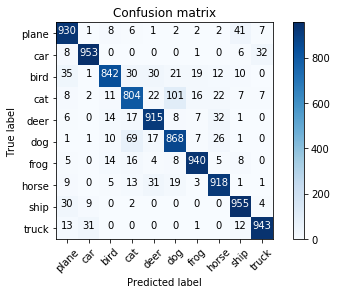

In [74]:
trained_model = train_model(model, criterion, optimizer)